<a href="https://colab.research.google.com/github/AlbertVong/Deep-Learning-Notes/blob/main/micrograd_scratch_andrej_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to follow along with Andrej Karpathy's lecture on setting up micrograd (a small library that performs basic neural computations with small matrices). This is to also understand how backward propagation works on a node level.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs = np.arange(-5,5,.25)
ys = f(xs)

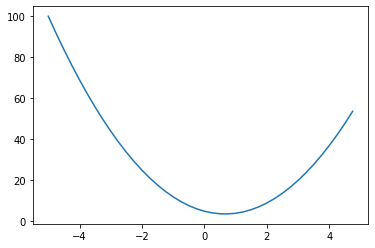

In [ ]:
plt.plot(xs,ys)

In [ ]:
h = 1e-5

In [ ]:
x = -3.0
f(x+h)
(f(x+h) - f(x))/h

-21.999970000052823

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 1e-4
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b + c
print('d1',d1)
print('d2', d2)

print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:

  #We need to introduce a method of keeping track of which values produce other values
  #Going to introduce a new variable called children
  #Children is an empty tuple, but is a set in the class

  #We also need to know which operation created the children (from even smaller blocks)
  #Creating _op to do this.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    #Prev is an empty set
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): #Enables us to print a nicer looking function in python, otherwise you get the reference object
    return f"Value(data={self.data})"

  def __add__(self, other): #underscores define basic operations in python. a+b -> a.__add__(b)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out



In [ ]:
from graphviz import Digraph

In [ ]:
def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [ ]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR means left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    #for value in graph, create rectangular ('record) node for it
    dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      #if this value is the result of some operation, create op node
      dot.node(name = uid + n._op, label = n._op)
      #connect the node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    #Connect n1 to op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)


  return dot

In [ ]:
draw_dot(L)

NameError: ignored

Let's now update the class **Value** to include a gradient, called grad

In [ ]:
class Value:

  #We need to introduce a method of keeping track of which values produce other values
  #Going to introduce a new variable called children
  #Children is an empty tuple, but is a set in the class

  #We also need to know which operation created the children (from even smaller blocks)
  #Creating _op to do this.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 #Initially, each variable does not affect whatever output is at the end of the forward pass
    #Prev is an empty set
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): #Enables us to print a nicer looking function in python, otherwise you get the reference object
    return f"Value(data={self.data})"

  def __add__(self, other): #underscores define basic operations in python. a+b -> a.__add__(b)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [ ]:
def lol():

  h = 1e-4

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

  



In [ ]:
lol()

6.000000000021544


In [ ]:
#Let's create a fake neuron to test our understanding
#Use tanh as squashing function

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights of neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of nn
b = Value(6.7, label='b')

#Raw body activation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh() #we need to implement exponentiation and divide

draw_dot(n)


AttributeError: ignored

In [ ]:
#Let's define tanh (we just need to know derivative wrt input for tanh(x))

class Value:

  #We need to introduce a method of keeping track of which values produce other values
  #Going to introduce a new variable called children
  #Children is an empty tuple, but is a set in the class

  #We also need to know which operation created the children (from even smaller blocks)
  #Creating _op to do this.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 #Initially, each variable does not affect whatever output is at the end of the forward pass
    #Prev is an empty set
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): #Enables us to print a nicer looking function in python, otherwise you get the reference object
    return f"Value(data={self.data})"

  def __add__(self, other): #underscores define basic operations in python. a+b -> a.__add__(b)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
    out = Value(t, (self, ), 'tanh')

    return out

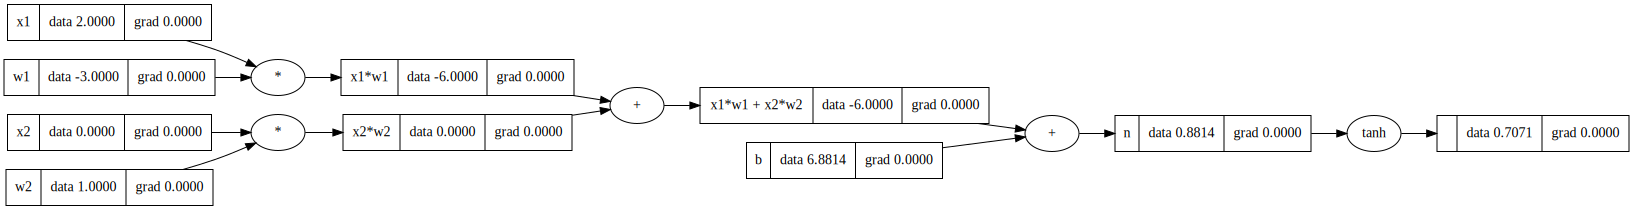

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights of neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of nn
b = Value(6.881373587, label='b')

#Raw body activation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh() #we need to implement exponentiation and divide

draw_dot(o)

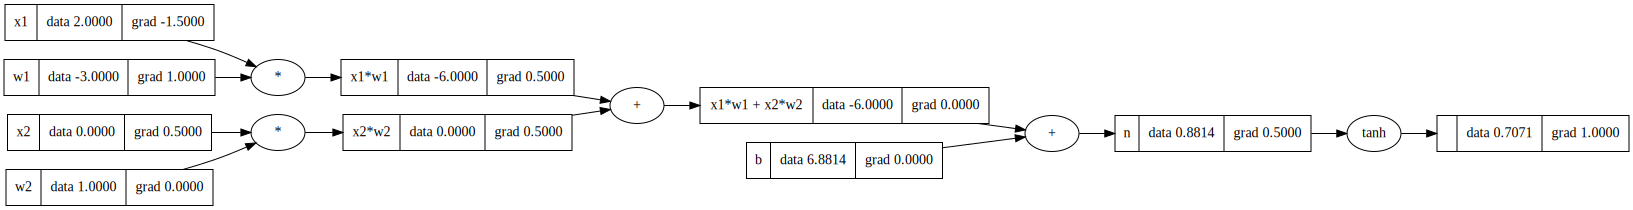

In [ ]:
#Let's calculate out the gradients
o.grad = 1
#do/dn = 1 - o^2
n.grad = 1 - o.data**2
#
x2w2.grad = n.grad
x1w1.grad = n.grad
#
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

draw_dot(o)


Now, let's add in gradient updates into our value function

In [ ]:
#Let's define tanh (we just need to know derivative wrt input for tanh(x))

class Value:

  #We need to introduce a method of keeping track of which values produce other values
  #Going to introduce a new variable called children
  #Children is an empty tuple, but is a set in the class

  #We also need to know which operation created the children (from even smaller blocks)
  #Creating _op to do this.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 #Initially, each variable does not affect whatever output is at the end of the forward pass
    #Prev is an empty set
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): #Enables us to print a nicer looking function in python, otherwise you get the reference object
    return f"Value(data={self.data})"

  def __add__(self, other): #underscores define basic operations in python. a+b -> a.__add__(b)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

In [ ]:
#Now let's call all the nodes backward in the right order.
#Let's reset the node gradients
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights of neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of nn
b = Value(6.881373587, label='b')

#Raw body activation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh() #we need to implement exponentiation and divide



In [ ]:
o.grad = 1.0



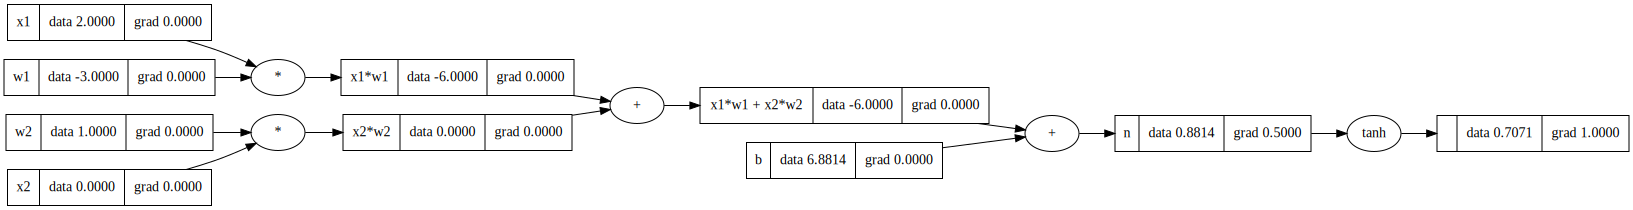

In [ ]:
o._backward()
draw_dot(o)

In [ ]:
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

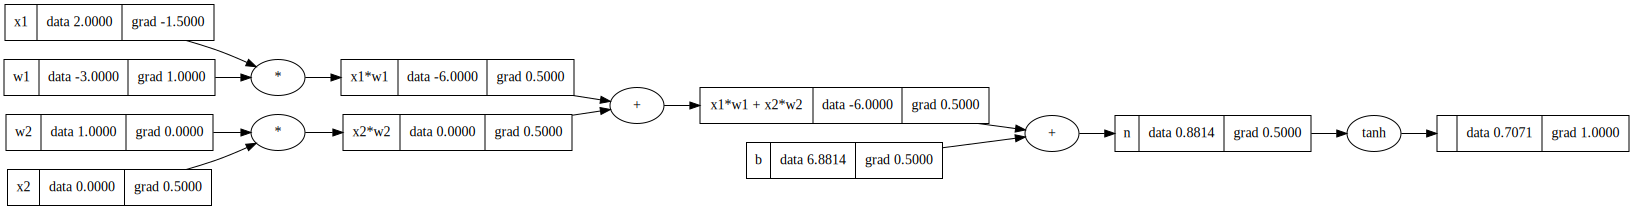

In [ ]:
#Going to build a topological graph (such that all nodes only point in one direction)
#This is how we build a liste of dependencies for backprop

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
  for child in v._prev:
    build_topo(child)
  topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

Now, let's hide the backward class and the topo set inside value class

# Now that we've figured out the derivations...

In [ ]:
#Let's define tanh in terms of exp, division
#Let's also introduce division as a * b^-1, and implement power instead

class Value:

  #We need to introduce a method of keeping track of which values produce other values
  #Going to introduce a new variable called children
  #Children is an empty tuple, but is a set in the class

  #We also need to know which operation created the children (from even smaller blocks)
  #Creating _op to do this.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 #Initially, each variable does not affect whatever output is at the end of the forward pass
    #Prev is an empty set
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): #Enables us to print a nicer looking function in python, otherwise you get the reference object
    return f"Value(data={self.data})"

  def __add__(self, other): #underscores define basic operations in python. a+b -> a.__add__(b)
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __sub__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    return self + (-other)

  def __rsub__(self, other):
    self = self if isinstance(self,Value) else Value(self)
    return (-self) + other

  def __mul__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)) #only allowing int or float powers for now
    out = Value(self.data ** other, (self,), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other-1.0)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): #Oh shit check for other * self if this exists in value
    return self * other #Just call the mul function

  def __neg__(self):
    return self * -1

  def __truediv__(self, other): #self / other
    return self * other**(-1)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    self = self if isinstance(self, Value) else Value(self)
    x = self.data
    e = math.exp(x)
    out = Value(e, (self, ), 'exp')

    def _backward():
      self.grad += e * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)

    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()


In [ ]:
#Let's try defining tanh in terms of its constituent functions
#Now let's call all the nodes backward in the right order.
#Let's reset the node gradients
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights of neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of nn
b = Value(6.881373587, label='b')

#Raw body activation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = ((2*n).exp() - 1) / ((2*n).exp() + 1)

ot = n.tanh()

o.data == ot.data


True

Now, let's use the pytorch api to do the same thing/

In [ ]:
import torch

In [ ]:
#casting single float to double float by using .double()
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373587]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #sum implicitly sums off of 0, but we can have it sum off of something else in the second argument 
    act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b) #creates a new iterator that iterates over the tuples of the constituent entries
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  

In [ ]:
x = [2.0, 3.0, 1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.3800003121211636)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

#Get current preds
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5377143529922795),
 Value(data=-0.13432861626083806),
 Value(data=-0.2515180282296919),
 Value(data=-0.5429076735559758)]

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.054741727206423)

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

-50.63193960956666

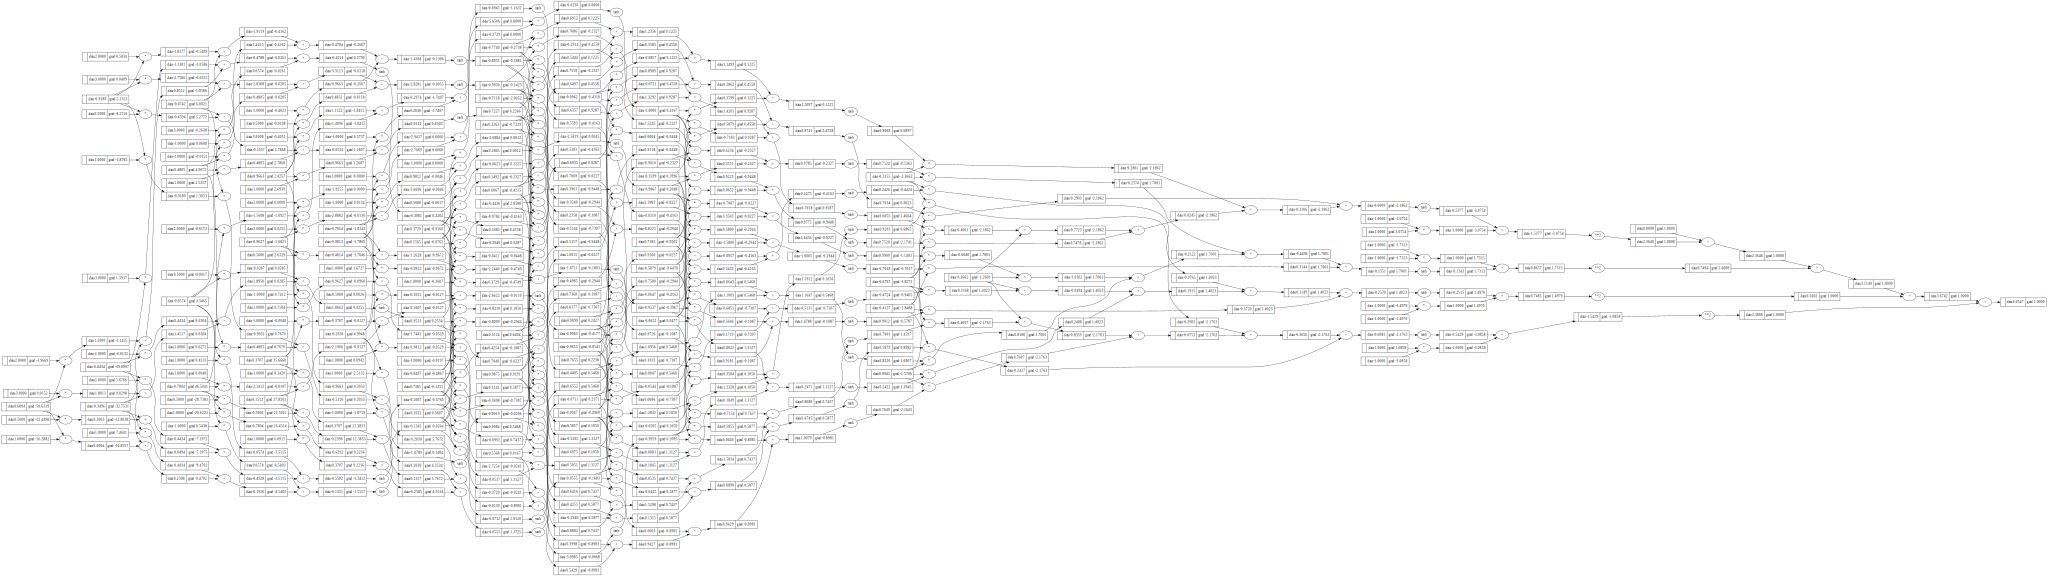

In [ ]:
draw_dot(loss)

In [ ]:
#We want to update each of these small weight values in the direction of the gradient
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.700370143541527)

In [ ]:
#Let's implement a training loop
x = [2.0, 3.0, 1.0]
n = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets



for k in range(20): #Number of steps
  #forward pass
  #Get current preds
  ypred = [n(x) for x in xs]
  loss = sum((pred-targ)**2 for pred, targ in zip(ypred, ys))

  #Backward pass to calculate gradients  
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #Updating weights using gradients
  lr = 0.05
  for p in n.parameters():
    p.data += -lr * p.grad
  #Print update
  print(f'Epoch {k}: Loss: {loss}\n-------------\n')
  



Epoch 0: Loss: Value(data=7.764427011028481)
-------------

Epoch 1: Loss: Value(data=7.300016958976657)
-------------

Epoch 2: Loss: Value(data=6.413988686410807)
-------------

Epoch 3: Loss: Value(data=3.7832677933010483)
-------------

Epoch 4: Loss: Value(data=3.3520150335201624)
-------------

Epoch 5: Loss: Value(data=3.179364724579595)
-------------

Epoch 6: Loss: Value(data=2.7486472023615525)
-------------

Epoch 7: Loss: Value(data=1.7631587005332923)
-------------

Epoch 8: Loss: Value(data=1.1430326059824578)
-------------

Epoch 9: Loss: Value(data=0.7828723099385072)
-------------

Epoch 10: Loss: Value(data=0.5441800617335227)
-------------

Epoch 11: Loss: Value(data=0.3947847483615627)
-------------

Epoch 12: Loss: Value(data=0.3143233571646693)
-------------

Epoch 13: Loss: Value(data=0.2573221029365338)
-------------

Epoch 14: Loss: Value(data=0.21655008086198058)
-------------

Epoch 15: Loss: Value(data=0.18590050686684662)
-------------

Epoch 16: Loss: Valu

In [ ]:
ypred


[Value(data=0.9995776394302979),
 Value(data=-0.8928177434063145),
 Value(data=-0.8935469234286267),
 Value(data=0.999572783668843)]

In [ ]:
#Building an example classifier using the demo classification code (binary classification)
